# **Imports**

Below are all the **Modules** used in the **Notebook**.

In [1]:
# Common
import os 
import keras 
import pandas as pd
import numpy as np
import tensorflow as tf
from IPython.display import clear_output as cls

# Data Visualization
import matplotlib.pyplot as plt
import plotly.express as px

# Data Loading
from keras.preprocessing.image import ImageDataGenerator as IDG

# Model 
import tensorflow_hub as hub
from keras.layers import Dense
from keras.models import Sequential, load_model

# Callbacks 
from keras.callbacks import EarlyStopping, ModelCheckpoint

# LR Scheduler
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay as PWCD
from tensorflow.keras.optimizers import SGD

# Metrics
from keras.metrics import SparseCategoricalAccuracy, SparseTopKCategoricalAccuracy

# **Data Information**

Before loading the data, let's have a look as the **Class Distribution**.

In [2]:
# Specify Data Path
path = '../input/yoga-posture-dataset'

# Class Name
class_names = sorted(os.listdir(path))
class_names.remove("Poses.json")
n_classes = len(class_names)

# Show
print(f"Total Number of Classes : {n_classes}")
print(f"Classes : \n{class_names}")

Total Number of Classes : 47
Classes : 
['Adho Mukha Svanasana', 'Adho Mukha Vrksasana', 'Alanasana', 'Anjaneyasana', 'Ardha Chandrasana', 'Ardha Matsyendrasana', 'Ardha Navasana', 'Ardha Pincha Mayurasana', 'Ashta Chandrasana', 'Baddha Konasana', 'Bakasana', 'Balasana', 'Bitilasana', 'Camatkarasana', 'Dhanurasana', 'Eka Pada Rajakapotasana', 'Garudasana', 'Halasana', 'Hanumanasana', 'Malasana', 'Marjaryasana', 'Navasana', 'Padmasana', 'Parsva Virabhadrasana', 'Parsvottanasana', 'Paschimottanasana', 'Phalakasana', 'Pincha Mayurasana', 'Salamba Bhujangasana', 'Salamba Sarvangasana', 'Setu Bandha Sarvangasana', 'Sivasana', 'Supta Kapotasana', 'Trikonasana', 'Upavistha Konasana', 'Urdhva Dhanurasana', 'Urdhva Mukha Svsnssana', 'Ustrasana', 'Utkatasana', 'Uttanasana', 'Utthita Hasta Padangusthasana', 'Utthita Parsvakonasana', 'Vasisthasana', 'Virabhadrasana One', 'Virabhadrasana Three', 'Virabhadrasana Two', 'Vrksasana']


We have **47 Classes**, as the **number of classes** is high it is **important** that the **Classes are equally distributed**.

In [3]:
# Calculate Class Dis
class_dis = [len(os.listdir(path + f"/{name}")) for name in class_names]

It's better to **Visualize** the **Class Distribution**.

In [4]:
# Pie Plot
fig = px.pie(names=class_names, values=class_dis, title="Class Distribution")
fig.update_layout({'title':{'x':0.5}})
fig.show()

# Bar Plot
fig = px.bar(x=class_names, y=class_dis, color=class_names)
fig.show()

All classes are **un-equally distributed**. Some classes have **extremely low number of images** when compared with other classes. Although, this is something expected, this can still **ruin our model's performance**. The model will **not be able to fully understand the features of low populated class**.

# **Data Loading**

We are aware of the **Class Distribution**, now its time to **Load the Data**.

In [5]:
# Initialize Generators
train_gen = IDG(rescale=1./255, rotation_range=10, validation_split=0.1)

We **cannot apply augmentation on this data set**. Especially, the **horizontal and vertical flip** because in real world examples, this is never going to happen. It can still happen in rare cases, but **in general, this does not happens**.

In [6]:
# Load Data
train_ds = train_gen.flow_from_directory(path, target_size=(256,256), class_mode='binary', shuffle=True, batch_size=32, subset='training')
valid_ds = train_gen.flow_from_directory(path, target_size=(256,256), class_mode='binary', shuffle=True, batch_size=32, subset='validation')

Found 2500 images belonging to 47 classes.
Found 256 images belonging to 47 classes.


# **Data Visualization**

We have the data in high let's look at **some images from this data set**.

In [7]:
def show_images(data, model=None, GRID=[5,6], SIZE=(25,25)):
    
    # Plot Configurations
    n_rows, n_cols = GRID
    n_images = n_rows * n_cols
    plt.figure(figsize=SIZE)
    
    i = 1
    for images, labels in iter(data):
        
        # Select Random Data
        
        id = np.random.randint(len(images))
        image, label = tf.expand_dims(images[id], axis=0), class_names[int(labels[id])]
        
        # Make Prediction
        if model is not None:
            pred = class_names[np.argmax(model.predict(image))]
            title = f"True : {label}\nPred : {pred}"
        else:
            title = f"{label}"
        
        # Show Data
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image[0])
        plt.axis('off')
        plt.title(title)
        
        # Break Loop Once Done
        i+=1
        if i>n_images:
            break
        cls()
    plt.show()

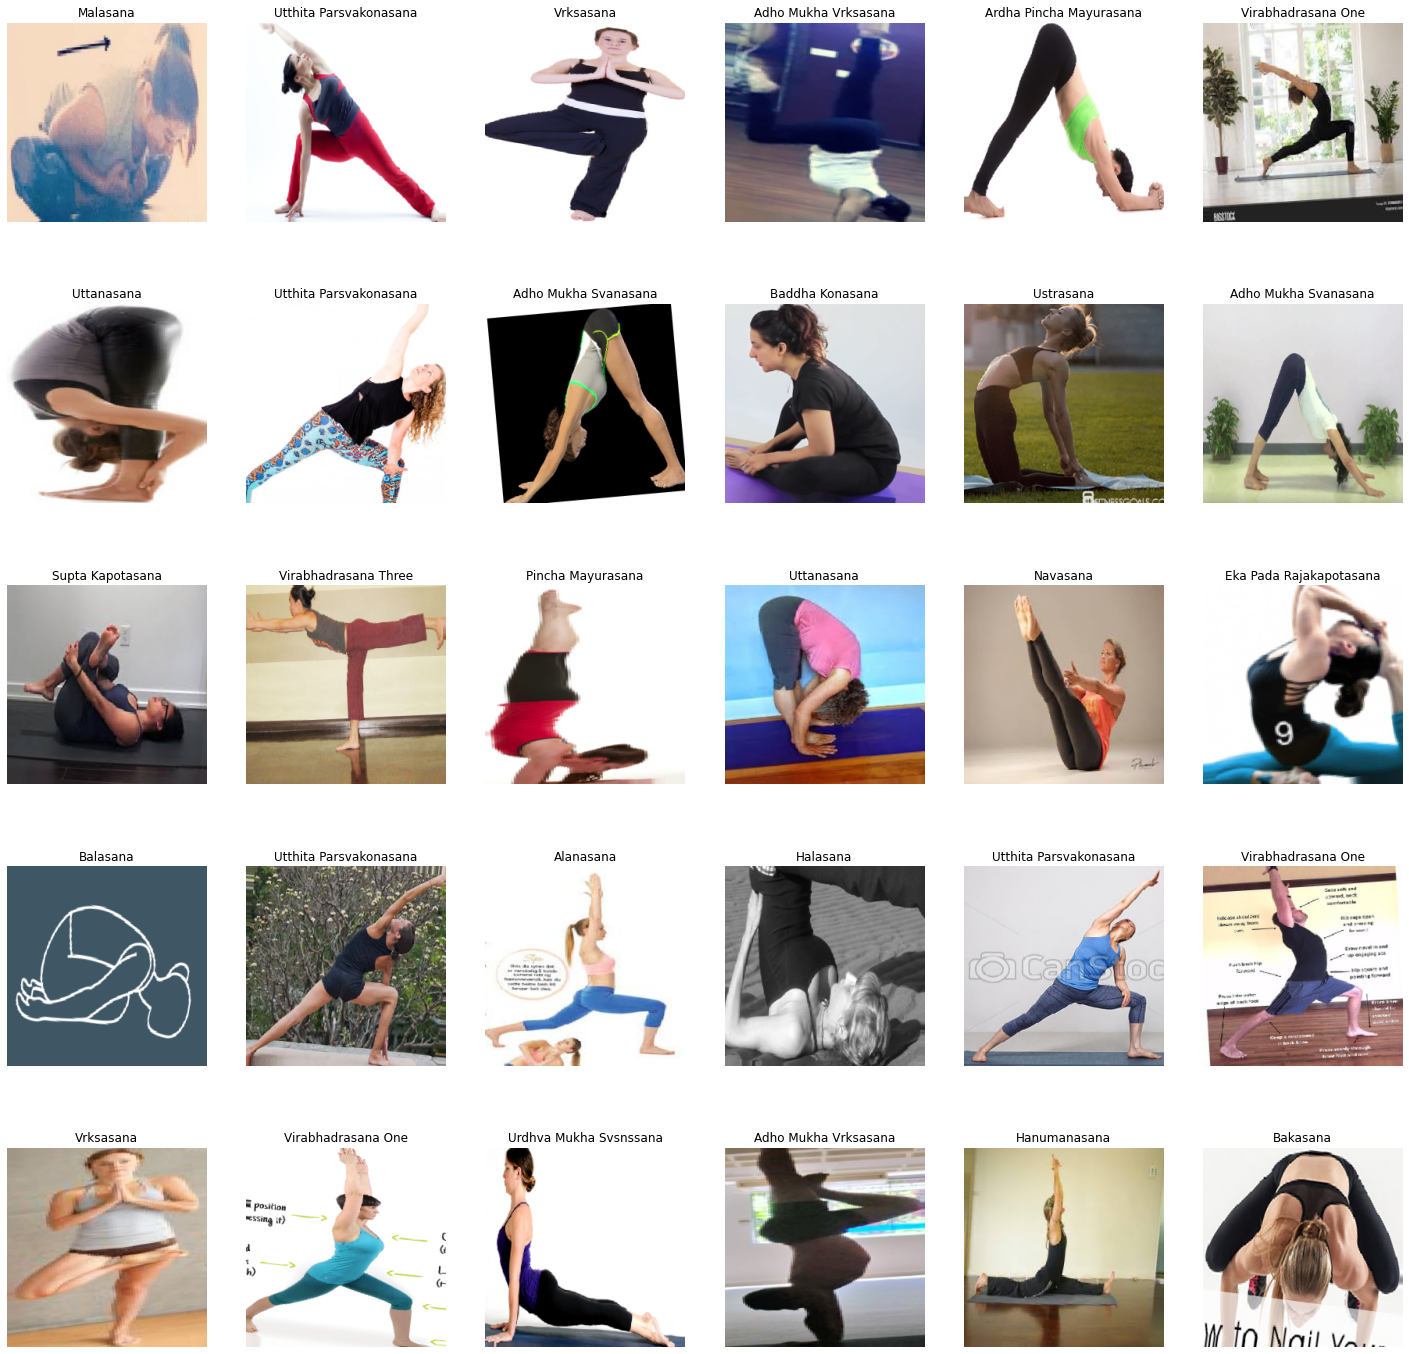

CPU times: user 22.3 s, sys: 1.04 s, total: 23.4 s
Wall time: 29.1 s


In [8]:
%%time
show_images(data=train_ds)

The model will have to **focus on the geometery of the human body** in order to classify which **"Asana"** It belongs to.

# **Big Transfer-BiT**

From architecture perspective **BiT** is nothing but a **4x times Scaled version of ResNet152V2**. The main idea here is of **Transfer Learning**, this model is **pre-trained on a Large Dataset**, so it can be trained on **sub-datasets** or basically other **small datasets** and as the **model is pre-trained on a Very large Dataset** it is expected that it will perform **extremely well on the small dataset**. There are **3 variants of BiT** :

* **BiT-L** : This is trained on **Image Classification task of 300M Samples(This is Private)**.
* **BiT-M** : This is trained on **Image Classification task of 14M Samples**.
* **BiT-S** : This is trained on **Image Classification task of 1.3M Samples**.

In this notebook, we are going to use the **BiT-M**. Let's load this model,

In [9]:
# Model URL
url = "https://tfhub.dev/google/bit/m-r50x1/1"

# Load Model
bit = hub.KerasLayer(url)

In [10]:
# Model Name
model_name = "Yoga-Posture-Detection-BiT"

# Model Architecture
model = Sequential([
    bit,
    Dense(n_classes, activation='softmax', kernel_initializer='zeros')
], name=model_name)

In [11]:
# Optimizer
learning_rate = 5e-2 * 32/512
lr_scheduler = PWCD(
    boundaries=[
        100,
        150,
        200
    ],
    values = [
        learning_rate,
        learning_rate*0.1,
        learning_rate*0.01,
        learning_rate*0.001
    ], name="LearningRate"
)
optimizer = SGD(learning_rate=lr_scheduler, momentum=0.9)
print(f"Learning Rate : {learning_rate}")

Learning Rate : 0.003125


In [12]:
# Compile Model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=[
        SparseCategoricalAccuracy(name="accuracy"),
        SparseTopKCategoricalAccuracy(k=3, name="Top3Acc")
    ]
)

Generally, we only look for the **single accuracy**, but it is better to look at the **top three or top five accuracy** to better understand the **model understanding**. Especially in **large datasets**.

In [13]:
# Callbacks
cbs = [
    EarlyStopping(patience=3, restore_best_weights=True), ModelCheckpoint(model_name+".h5", save_best_only=True)
]

In [14]:
# Train Model
history = model.fit(
    train_ds, 
    validation_data=valid_ds,
    epochs=10, # With the right learning rate, only 5 will also work.
    callbacks=cbs
)

Epoch 1/10
 5/79 [>.............................] - ETA: 55s - loss: 4.4163 - accuracy: 0.0375 - Top3Acc: 0.3125

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



79/79 [==============================] - 84s 907ms/step - loss: 7.0341 - accuracy: 0.2376 - Top3Acc: 0.4260 - val_loss: 4.8284 - val_accuracy: 0.4062 - val_Top3Acc: 0.5977
Epoch 2/10
79/79 [==============================] - 63s 795ms/step - loss: 3.3167 - accuracy: 0.5752 - Top3Acc: 0.7580 - val_loss: 2.0630 - val_accuracy: 0.6367 - val_Top3Acc: 0.8164
Epoch 3/10
79/79 [==============================] - 63s 792ms/step - loss: 1.1172 - accuracy: 0.7744 - Top3Acc: 0.9236 - val_loss: 1.8622 - val_accuracy: 0.6836 - val_Top3Acc: 0.8477
Epoch 4/10
79/79 [==============================] - 63s 799ms/step - loss: 0.9745 - accuracy: 0.8004 - Top3Acc: 0.9352 - val_loss: 1.8747 - val_accuracy: 0.6914 - val_Top3Acc: 0.8438
Epoch 5/10
79/79 [==============================] - 63s 791ms/step - loss: 0.9715 - accuracy: 0.8008 - Top3Acc: 0.9352 - val_loss: 1.8286 - val_accuracy: 0.6797 - val_Top3Acc: 0.8555
Epoch 6/10
79/79 [==============================] - 63s 796ms/step - loss: 0.9473 - accuracy: 0.

The **imbalance between training and validation accuracy** is expected because of the **small size of data set** compared to the **BIT model architecture**.

# **Learning Curve**

In [15]:
data = pd.DataFrame(history.history)
data

,loss,accuracy,Top3Acc,val_loss,val_accuracy,val_Top3Acc
0,7.034052,0.2376,0.4260,4.828436,0.406250,0.597656
1,3.316687,0.5752,0.7580,2.062960,0.636719,0.816406
2,1.117152,0.7744,0.9236,1.862155,0.683594,0.847656
3,0.974469,0.8004,0.9352,1.874658,0.691406,0.843750
4,0.971452,0.8008,0.9352,1.828635,0.679688,0.855469
5,0.947317,0.8084,0.9352,1.810989,0.695312,0.843750
6,0.948584,0.8032,0.9396,1.810175,0.699219,0.839844
7,0.936386,0.8080,0.9408,1.781510,0.710938,0.871094
8,0.916682,0.8148,0.9416,1.791988,0.675781,0.851562
9,0.890989,0.8192,0.9476,1.855998,0.652344,0.855469


In [16]:
def plot_learning_curve(history):
    data = pd.DataFrame(history)
    
    plt.style.use('fast')
    plt.figure(figsize=(25,8))

    plt.subplot(1,3,1)
    plt.title("Loss Curve")
    plt.plot(data['loss'], label="Loss")
    plt.plot(data['val_loss'], label="Val Loss")
    plt.xlabel("Epochs")
    plt.legend(fontsize=15)
    plt.ylabel("Loss")

    plt.subplot(1,3,2)
    plt.title("Accuracy Curve")
    plt.plot(data['accuracy'], label="Accuracy")
    plt.plot(data['val_accuracy'], label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.legend(fontsize=15)
    plt.ylabel("Accuracy")

    plt.subplot(1,3,3)
    plt.title("Top 3 Accuracy Curve")
    plt.plot(data['Top3Acc'], label="Top 3 Accuracy")
    plt.plot(data['val_Top3Acc'], label="Top 3 Val Accuracy")
    plt.xlabel("Epochs")
    plt.legend(fontsize=15)
    plt.ylabel("Accuracy")
    
    plt.show()

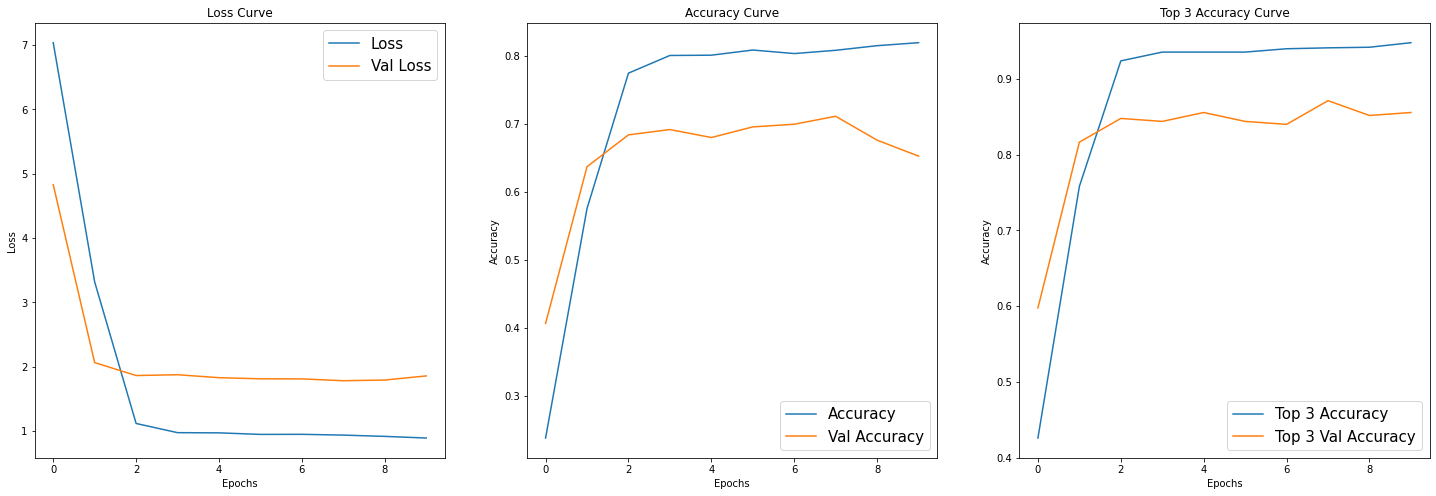

In [17]:
plot_learning_curve(history.history)

# **Model Evaluation**

In [18]:
model.evaluate(valid_ds)

8/8 [==============================] - 6s 763ms/step - loss: 1.7692 - accuracy: 0.7109 - Top3Acc: 0.8594


[1.7692108154296875, 0.7109375, 0.859375]

# **Model Prediction**

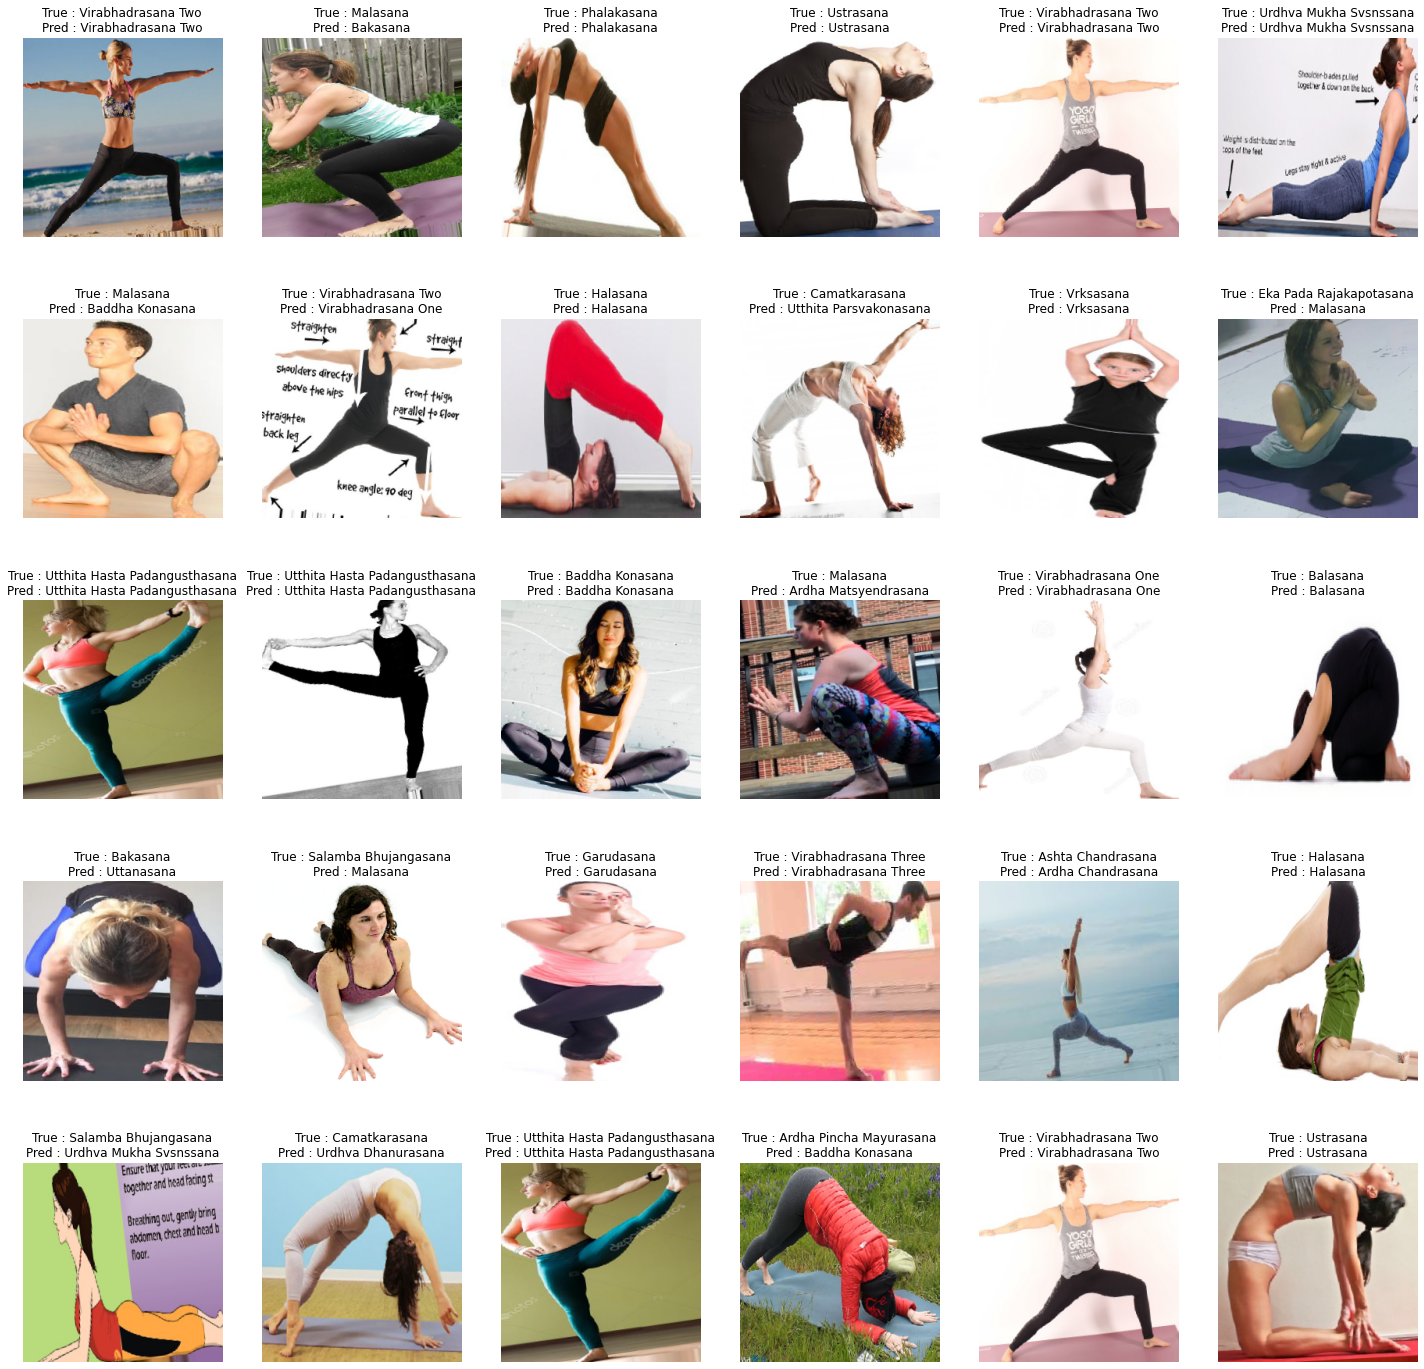

In [19]:
show_images(data=valid_ds, model=model)

Despite having a **relatively low accuracy**, almost all **predictions are correct**. This shows the **high robustness** of the **BiT model**. 

**Thank You**, Let me know your **suggestions in the comments**.

---
**DeepNets**